In [21]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import dnnlib.tflib as tflib
import dnnlib

_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

In [22]:
def get_sylegan_networks(path_or_url):
    if dnnlib.util.is_url(path_or_url):
        stream = dnnlib.util.open_url(path_or_url, cache_dir='.stylegan2-cache')
    else:
        stream = open(path_or_url, 'rb')

    tflib.init_tf()
    with stream:
        G, D, Gs = pickle.load(stream, encoding='latin1')

    return G, D, Gs

In [29]:
def generate_images(path_or_url, batch_size, truncation_psi = None):
    G, D, Gs = get_sylegan_networks(path_or_url)
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    imgs = []
    for i in range(batch_size):
        rnd = np.random.RandomState()
        z = rnd.randn(1, *Gs.input_shape[1:])
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars})
        img = Gs.run(z, None, **Gs_kwargs)
        imgs.append(img[0])
        
    fig = plt.figure(figsize=(64., 64.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
    
    for ax, im in zip(grid, imgs):
        ax.imshow(im)
        
    plt.show()

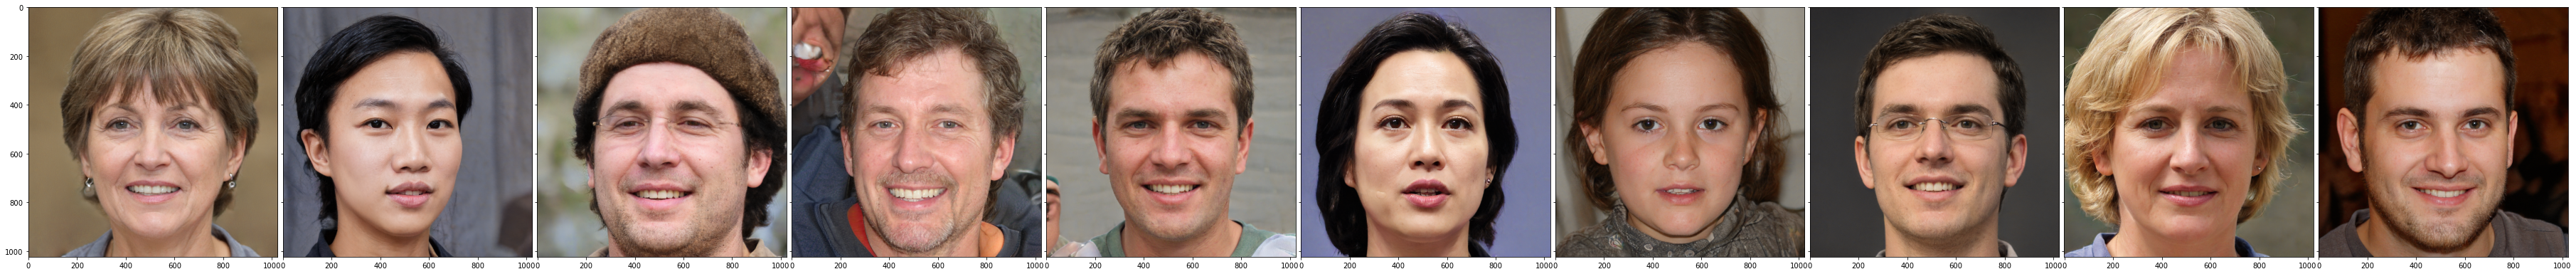

In [30]:
generate_images(_stylegan_ffhq_f_gdrive_url, 10)